In [1]:
from itertools import chain
import numpy as np
from midiutil import *
import pygame

import subprocess
from collections.abc import Sequence

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
working_pygame = False

track = 0
channel = 0
#pitch = 120
pitch = 60
pitch1 = 60
time = 0
duration = 1
volume = 100


In [3]:
def blank_midifile():
    MyMIDI = MIDIFile(1)
    return MyMIDI

#for i in range(12):
#    MyMIDI.addNote(track,channel,pitch+i,time+i,duration,volume)

In [4]:
if working_pygame:
    # mixer config
    freq = 44100  # audio CD quality
    bitsize = 16   # unsigned 16 bit
    channels = 2  # 1 is mono, 2 is stereo
    buffer = 1024   # number of samples
    pygame.mixer.init(freq, bitsize, channels, buffer)

    # optional volume 0 to 1.0
    pygame.mixer.music.set_volume(0.8)

    def play_music(midi_filename):
        '''Stream music_file in a blocking manner'''
        clock = pygame.time.Clock()
        pygame.mixer.music.load(midi_filename)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            clock.tick(30) # check if playback has finished
else:
    def play_music(midi_filename):
        subprocess.run(['timidity', midi_filename])

In [139]:
intervals = {'1':0,
             'b1':1,
             '2':2,
             'b3':3,
             '3':4,
             '4':5,
             'b5':6,
             '5':7,
             'b6':8,
             '6':9,
             'b7':10,
             '7':11,
             '8':12
            }

In [140]:
class Scale(Sequence):
    def __init__(self, *constituents):
        super(Scale, self).__init__()
        self._list = constituents
        
    def __repr__(self):
        return f"<{self.__class__.__name__} {self._list}>"
    
    def __len__(self):
        return len(self._list)
    
    def __getitem__(self, ii):
        if isinstance(ii, int):
            relative_octave = 0
            while ii < 0:
                relative_octave -= 1
                ii += len(self)
            while len(self._list) <= ii:
                relative_octave += 1
                ii -= len(self)
            return self._list[ii] + 12 * relative_octave
        elif isinstance(ii, slice):
            if ii.start is None:
                ii = slice(0, ii.stop, ii.step)
            if ii.stop is None:
                ii = slice(ii.start, len(self), ii.step)
            if ii.step is None:
                ii = slice(ii.start, ii.stop, 1)
            output = []
            while ii.start < ii.stop:
                output.append(self[ii.start])
                ii = slice(ii.start+ii.step, ii.stop, ii.step)
            return output
        else:
            raise TypeError("index must be int or slice")
    

In [141]:
major = [0, 2, 4, 5, 7, 9, 11] + [12 + x for x in [0, 2, 4, 5, 7, 9, 11]]
major_o = Scale(0, 2, 4, 5, 7, 9, 11)

print(len(major_o))

[major_o[x] for x in range(-5, 12)]

7


[-8, -7, -5, -3, -1, 0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19]

In [142]:
major_o

<Scale (0, 2, 4, 5, 7, 9, 11)>

In [143]:
def major_chord(chord_numeral, jazzness=0):
    # take two octaves of scale, starting on chord_numeral
    scale = major_o[chord_numeral-1:chord_numeral-1+7*2]
    # take every other node and return triad + jazzness
    return scale[::2][:3+jazzness]
major_chord(5, 2)

[7, 11, 14, 17, 21]

In [144]:
major_chord(1, 1)

[0, 4, 7, 11]

In [145]:
class Tone:
    def __init__(self, root, interval, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        if type(interval) == str:
            self.interval = intervals[interval]
        else:
            self.interval = interval
        self.duration = duration
        self.volume = volume
        
    #def __getattr__(self, name):
    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        midi_file.addNote(track, channel, self.root + self.interval, time, self.duration, self.volume)

In [146]:
class Chord:
    def __init__(self, root, constituents, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        self.constituents = []
        for interval in constituents:
            if type(interval) == str:
                self.constituents.append(intervals[interval])
            else:
                self.constituents.append(interval)
        self.duration = duration
        self.volume = volume

    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        for interval in self.constituents:
            midi_file.addNote(track, channel, self.root + interval, time, self.duration, self.volume)

In [154]:
def interval2pitch(ints):
    return list(map(lambda x: intervals[x], ints))

In [161]:
#major_scale = np.array([0,2,4,5,7,9,11])
#major_blues = np.array(interval2pitch(['1','2','b3','3','5','6']))
minor_blues = np.array(interval2pitch(['1','b3','4','b5','5','b7']))

In [162]:
scale = minor_blues
scale_probabilities = np.eye(12)[scale].sum(0)/len(scale)

In [163]:
def bjorklund(m,k,rhythm = None):
    # generates Euclidean rhythms, i.e. rhythms where beats are spread out as evenly as possible across the measure
    # this is basically euclid's algorithm, see http://cgm.cs.mcgill.ca/~godfried/publications/banff.pdf
    if rhythm is None:
        rhythm = k*[[1]] + (m-k)*[[0]]
    if m%k == 0:
        # flatten list
        return [beat for seq in rhythm for beat in seq]
    else:
        if k>m-k:
            rhythm = [seq+rhythm[-1] if i<(m%k) else seq for i,seq in enumerate(rhythm[:k])]
        else:
            rhythm = [seq+rhythm[-1] if i<k else seq for i,seq in enumerate(rhythm[:k+(m%k)])]
        return bjorklund(k,m%k,rhythm)

In [164]:
bjorklund(5,2)

[1, 0, 1, 0, 0]

In [219]:
melody = []
signs = []
#rhythm = []
n_bars = 4
euclidean_rhythm = bjorklund(8,5) # cinquillo
#euclidean_rhythm = bjorklund(13,5) # tresillo
#euclidean_rhythm = bjorklund(2,3)
#euclidean_rhythm = bjorklund(7,3)

# interpret 1's as onsets, and 0's as continuation
rhythm_in_measure = [0.5*(len(i)+1)for i in ''.join(map(str,euclidean_rhythm)).split('1')[1:]]
#rhythm_in_measure = [0.25*(len(i)+1)for i in ''.join(map(str,euclidean_rhythm)).split('1')[1:]]
rhythm = n_bars*rhythm_in_measure
for _ in range(n_bars):
    length = 0
    for i in range(len(rhythm_in_measure)):
    #while length < 4:
        note = np.random.choice(range(0, 12), size = 1, p = scale_probabilities)
        #sign = np.random.choice([-1,1],size=1)
        #sign = 1
        #duration = np.random.choice([0.25,0.5,1,1.25, 1.5, 1.75, 2], size=1)
        #duration = np.random.choice([0.25,0.5,1, 2], size=1)
        
        melody.append(note)
        #signs.append(sign)
        #if duration > (4 - length):
        #    duration = 4 - length
        #rhythm.append(duration)
        #length += duration
melody = np.array(melody).flatten()
rhythm = np.array(rhythm).flatten()
signs = np.array(signs).flatten()

In [220]:
def add_chord_progression(chord_progression, beats_per_chord = None, jazz = 0):
    if beats_per_chord is None:
        beats_per_chord = len(chord_progression)*[4]
    elif type(beats_per_chord) == int:
        beats_per_chord = len(chord_progression)*[beats_per_chord]
        
    chord = Chord(pitch, major_chord(chord_progression[0], jazzness=jazz), duration=beats_per_chord[0])
    chord.add_note(midi_file, track, channel+1)
    for ch,duration in zip(chord_progression[1:],beats_per_chord[1:]):
        chord = Chord(pitch, major_chord(ch, jazzness=jazz), duration=duration, parent=chord)
        chord.add_note(midi_file, track, channel+1)

In [221]:
def add_melody(pitches, rhythm):
    random_music = []
    random_music.append(Tone(60, pitches[0], rhythm[0], time=0))
    for interval, duration in zip(pitches[1:], rhythm[1:]):
        random_music.append(Tone(pitch, interval, duration, parent=random_music[-1]))

    for x in random_music:
        x.add_note(midi_file, track, channel)
    return random_music

In [222]:
midi_file = blank_midifile()
midi_file.addProgramChange(track, channel+1, 0, 8)

In [226]:
melody = np.tile(melody[:5],4*4)
rhythm = np.tile(rhythm,4)

#melody = np.tile(melody[:4],5)

In [229]:
# common jazz progression II-V-I
#add_chord_progression([2,5,1,1], jazz=1)

# pachabel's canon I-V-vi-iii-IV-I-IV-V
#add_chord_progression([1,5,4,3,4,1,4,5], beats_per_chord = 2, jazz=0)

# four chord song
#add_chord_progression([6,4,1,5], beats_per_chord = 4, jazz=0)
#add_chord_progression([1,5,6,4], beats_per_chord = 4, jazz=0)

# 12-bar blues
add_chord_progression([1,1,1,1,4,4,1,1,5,4,1,1], beats_per_chord = 2, jazz=0)

# blues
#add_chord_progression([1,4,1,1,4,4,1,1,5,4,1,5], beats_per_chord = 4, jazz=0)

music = add_melody(melody, rhythm)

In [230]:
for midi_track in midi_file.tracks:
    midi_track.closeTrack()
with open('tmp.mid','wb') as f:
    midi_file.writeFile(f)

play_music('tmp.mid')

KeyboardInterrupt: 

In [ ]:
import matplotlib.pylab as plt

In [91]:
x = np.cumsum(rhythm)

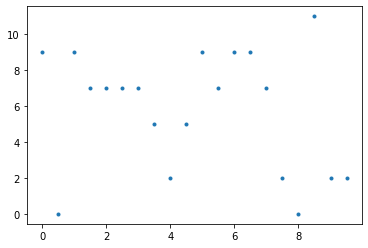

In [92]:
plt.plot([0] + list(x[:-1]), melody,'.')

In [35]:
midi_file = blank_midifile()
the_lick = []
the_lick.append(Tone(pitch, 1, 0.5, time=0))
for interval, duration in [(2, 0.5), (3, 0.5), (5, 0.5), (2, 1), (-2, 0.5), (0, 1.5)]:
    the_lick.append(Tone(pitch, interval, duration, parent=the_lick[-1]))

for x in the_lick:
    x.add_note(midi_file, track, channel)